In [1]:
import netCDF4
import matplotlib.pyplot as plt
import pyugrid

import matplotlib.collections
import matplotlib.patches
import matplotlib.colors
import cmocean.cm
import numpy as np


%matplotlib inline

print('netcdf4', netCDF4.__version__)
print('pyugrid', pyugrid.__version__)

netcdf4 1.2.4
pyugrid 0.2.2


In [2]:
# a model of the Western Scheldt
# The Western Scheldt is the access point to the Port of Antwerp. 
url = ('http://opendap.deltares.nl/thredds/dodsC/opendap'
       '/deltares/Delft3D/netcdf_example_files/westernscheldt_sph_map.nc')

In [3]:
ds = netCDF4.Dataset(url)
ug = pyugrid.UGrid.from_nc_dataset(ds)

In [4]:
# coordinates of all the nodes in the faces
faces = ug.nodes[ug.faces]
# lookup velocity in x,y directions at last timestep
ucx = ds.variables['mesh2d_ucx'][-1,:]
ucy = ds.variables['mesh2d_ucy'][-1,:]
# compute absolute velocity
var = np.sqrt(ucx**2 +  ucy**2)

In [8]:
domain = 0, var.max()
# define a normalization function
N = matplotlib.colors.Normalize(*domain)
# pick a corresponding colormap
cmap = cmocean.cm.speed

# Let's draw general polygons
patches = (matplotlib.patches.Polygon(face) for face in faces)
# add them all at once
patch_collection = matplotlib.collections.PatchCollection(patches, edgecolor='none')
# set the face colors to the color of the data
patch_collection.set_facecolor(cmap(N(var)))

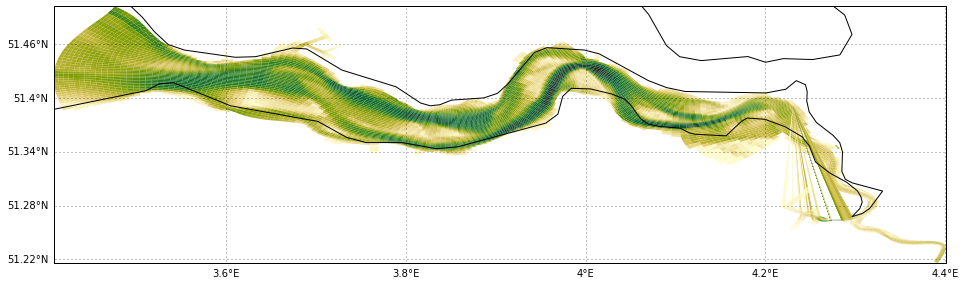

In [9]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 6),
                           subplot_kw=dict(projection=projection))
    ax.coastlines(resolution='10m', zorder=1)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax
fig, ax = make_map()
ax.add_collection(patch_collection)
ax.autoscale()

In [3]:
# minimal file based on cf-conventions
import netCDF4
ds = netCDF4.Dataset('quad_and_triangle.nc', 'w', datamodel='NETCDF4')


In [1]:
ds.createDimension('nMesh2_node', 5)
ds.createDimension('nMesh2_edge', 6)
ds.createDimension('nMesh2_face', 2)
ds.createDimension('nMaxMesh2_face_nodes', 2)
ds.createDimension('two', 2)


mesh2 = ds.createVariable('Mesh2', 'int32')
mesh2_attributes = dict(
    cf_role = "mesh_topology",
    long_name = "Topology data of 2D unstructured mesh",
    topology_dimension = 2,
    node_coordinates = "Mesh2_node_x Mesh2_node_y",
    face_node_connectivity = "Mesh2_face_nodes",
    face_dimension = "nMesh2_face",
    edge_node_connectivity = "Mesh2_edge_nodes", # attribute required if variables will be defined on edges
    edge_dimension = "nMesh2_edge",
    edge_coordinates = "Mesh2_edge_x Mesh2_edge_y", # optional attribute (requires edge_node_connectivity)
    face_coordinates = "Mesh2_face_x Mesh2_face_y", # optional attribute
    face_edge_connectivity = "Mesh2_face_edges" # optional attribute (requires edge_node_connectivity)
    face_face_connectivity = "Mesh2_face_links" # optional attribute
    edge_face_connectivity = "Mesh2_edge_face_links" # optional attribute (requires edge_node_connectivity)
)

mesh2_face_nodes = ds.createVariable('Mesh2_face_nodes', 'int32', dimensions=('nMesh2_face', 'nMaxMesh2_face_nodes'))
mesh2_face_nodes_attrs = dict(
    cf_role = "face_node_connectivity",
    long_name = "Maps every face to its corner nodes.",
    _FillValue = 999999,
    start_index = 1
)    
mesh2_edge_nodes = ds.createVariable('Mesh2_edge_nodes', 'int32', dimensions=('nMesh2_edge', 'two'))
mesh2_edge_nodes_attrs = dict(
    cf_role = "edge_node_connectivity",
    long_name = "Maps every edge to the two nodes that it connects.",
    start_index = 1
)
# Optional mesh topology variables
mesh2_face_edges = ds.createVariable('Mesh2_face_edges', 'int32', dimensions=('nMesh2_face', 'nMaxMesh2_face_nodes'))
mesh2_face_edges_attrs = dict(
    cf_role = "face_edge_connectivity",
    long_name = "Maps every face to its edges.",
    _FillValue = 999999,
    start_index = 1
)

integer Mesh2_face_links(nMesh2_face, nMaxMesh2_face_nodes) ;
Mesh2_face_links:cf_role = "face_face_connectivity" ;
Mesh2_face_links:long_name = "Indicates which other faces neighbor each face." ;
Mesh2_face_links:_FillValue = 999999 ;
Mesh2_face_links:start_index = 1 ;
Mesh2_face_links:flag_values = -1 ;
Mesh2_face_links:flag_meanings = "out_of_mesh" ;
integer Mesh2_edge_face_links(nMesh2_edge, Two) ;
Mesh2_edge_face_links:cf_role = "edge_face_connectivity" ;
Mesh2_edge_face_links:long_name = "neighbor faces for edges" ;
Mesh2_edge_face_links:start_index = 1 ;
Mesh2_edge_face_links:_FillValue = -999 ;
Mesh2_edge_face_links:comment = "missing neighbor faces are indicated using _FillValue" ;

// Mesh node coordinates
double Mesh2_node_x(nMesh2_node) ;
Mesh2_node_x:standard_name = "longitude" ;
Mesh2_node_x:long_name = "Longitude of 2D mesh nodes." ;
Mesh2_node_x:units = "degrees_east" ;
double Mesh2_node_y(nMesh2_node) ;
Mesh2_node_y:standard_name = "latitude" ;
Mesh2_node_y:long_name = "Latitude of 2D mesh nodes." ;
Mesh2_node_y:units = "degrees_north" ;

// Optional mesh face and edge coordinate variables
double Mesh2_face_x(nMesh2_face) ;
Mesh2_face_x:standard_name = "longitude" ;
Mesh2_face_x:long_name = "Characteristics longitude of 2D mesh face." ;
Mesh2_face_x:units = "degrees_east" ;
Mesh2_face_x:bounds = "Mesh2_face_xbnds" ;
double Mesh2_face_y(nMesh2_face) ;
Mesh2_face_y:standard_name = "latitude" ;
Mesh2_face_y:long_name = "Characteristics latitude of 2D mesh face." ;
Mesh2_face_y:units = "degrees_north" ;
Mesh2_face_y:bounds = "Mesh2_face_ybnds" ;
double Mesh2_face_xbnds(nMesh2_face,nMaxMesh2_face_nodes) ;
Mesh2_face_xbnds:standard_name = "longitude" ;
Mesh2_face_xbnds:long_name = "Longitude bounds of 2D mesh face (i.e. corner coordinates)." ;
Mesh2_face_xbnds:units = "degrees_east" ;
Mesh2_face_xbnds:_FillValue = 9.9692099683868690E36;
double Mesh2_face_ybnds(nMesh2_face,nMaxMesh2_face_nodes) ;
Mesh2_face_ybnds:standard_name = "latitude" ;
Mesh2_face_ybnds:long_name = "Latitude bounds of 2D mesh face (i.e. corner coordinates)." ;
Mesh2_face_ybnds:units = "degrees_north" ;
Mesh2_face_ybnds:_FillValue = 9.9692099683868690E36;
double Mesh2_edge_x(nMesh2_edge) ;
Mesh2_edge_x:standard_name = "longitude" ;
Mesh2_edge_x:long_name = "Characteristic longitude of 2D mesh edge (e.g. midpoint of the edge)." ;
Mesh2_edge_x:units = "degrees_east" ;
double Mesh2_edge_y(nMesh2_edge) ;
Mesh2_edge_y:standard_name = "latitude" ;
Mesh2_edge_y:long_name = "Characteristic latitude of 2D mesh edge (e.g. midpoint of the edge)." ;
Mesh2_edge_y:units = "degrees_north" ;
// bounds variables for edges skipped

SyntaxError: invalid syntax (<ipython-input-1-0e7cd8e82bde>, line 3)